In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as plot_style
import sys
plot_style.use('plots.mplstyle')

In [2]:
from virtual_lab.experiments import *
from virtual_lab.simulation import *
from virtual_lab.model import *
from virtual_lab.utils import *
Sim = Simulation()

Initializing a simulation without a given model. A model should be added before running any experiment by calling Simulation.add_model()
Resetting variable colors...


In [3]:
#TODO : Add 0.2 Hz experiments


In [4]:
variable_labels = {
    "Vpsd": r'$V_{PSD}$',
    "V_tot": r'$V_{tot}$',
    "Vd": r'$V_d$',
    "Vs": r'$V_s$',
    "V_eff": r'$V_{eff}$',
    "Ve": r'$V_m$', 
    "crosslink": 'cross.',
    "stim": "HFS"
}

# Trying out different models

## Model with normal $V_d$ non linearity and $V_eff$

In [5]:
class BaseModel(Model):
    def latex_equations(self):
        eq = [r'$\frac{dV_d}{dt} = \mathrm{b}n_f(t) + \left(\frac{V_{PSD}-V_s-V_d}{\tau_V}\right)\frac{V_d}{V_{d,eq}} + k_uV_s - k_bV_d$',
              r'$\frac{dV_s}{dt} = k_bV_d - k_uV_s$',
              r'$\frac{dV_{PSD}}{dt} = \phi(t)\frac{V_d+V_s-V_{eff}}{\tau_{PSD}}$',
              r'$V_{eff} = \mathrm{sol}\left(\frac{dV_d}{dt}+\frac{dV_s}{dt} = 0\right)(V_{PSD})$']
        return eq

    def diff_equations_dict(self):
        #super().list_of_equations(variables)
        needed_variables = ["Vd","Vs","Vpsd"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model, but was not given at initialisation")
        return {
            "Vd": self.dVd,
            "Vs": self.dVs,
            "Vpsd": self.dPSD
        }
    def equations_dict(self):
        needed_variables = ["V_eff"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model, but was not given at initialisation")
        return {
            "V_eff": self.V_eff_calc,
            "V_tot": self.V_tot_calc
        }

    def set_initial_values(self,stochastic_simulation):
        self.eql  = self.k_u_0/self.k_b_0 / (1+self.k_u_0/self.k_b_0)
        self.eql2  = self.k_u_1/self.k_b_1 / (1+self.k_u_1/self.k_b_1)
        if stochastic_simulation:
            # This is a bit of a cheat, but I'll check if without this it still works.
            # TODO: check!
            self.nf_0 = np.mean(self.nf)
        self.variables.V_eff = self.nu*self.nf_0*self.tau_Vd + self.variables.Vpsd 
        self.variables.Vd =  self.eql    * self.variables.V_eff
        self.variables.Vs = (1-self.eql) * self.variables.V_eff
        self.Vd_0 = self.variables.Vd 
        self.variables.V_tot = self.variables.Vs + self.variables.Vd
    
    def quantity_dependencies(self):
        needed_quantities = ["k_u_1","k_b_1","nf_LTD","nf_LTP"]
        for q in needed_quantities:
            if not hasattr(self,q):
                raise AttributeError(f"The following quantity is not defined in the model, but it is needed by the experimental procedure {q}\n"
                "Make sure you define all the needed constants before running a simulation")
        dependencies = {
            "k_u": {"crosslink": self.k_u_1},
            "k_b": {"crosslink": self.k_b_1},
            "protein": {"protein": 1},
            "nf": {"stim": self.nf_LTP,
                     "LFS": self.nf_LTD},
            "gamma": {"stim": self.g_mul_LTP*self.gamma_0,
                      "LFS": self.g_mul_LTD*self.gamma_0},
            "mu" : {"stim": self.m_mul_LTP*self.mu_0,
                    "LFS": self.m_mul_LTD*self.mu_0}
        }
        return dependencies
    
    def stochastic_variables_dict(self):
        stochastic_variables = {
            "nf" : (bd_process,["gamma","mu"])
        }
        return stochastic_variables
            
    # def termalization_step(self,t):
    #     var = {}
    #     var["Vd"] = self.dVd( t) 
    #     # Vs grows and shrinks through x-linker binding and unbinding
    #     var["Vs"] = self.dVs(t)
    #     self.variables.diff_timestep(var,self.dt)

    def dVd(self,t): # Vd with V-dependent removal: Dynamic pool shrinks if V>PST_str, Growth with number of foci 
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        return self.nu*self.nf[t]*(Vd/self.Vd_0)**self.AFB  - (Vd+Vs-Vpsd)/self.tau_Vd*(Vd/self.Vd_0)**self.DVD  - self.k_b[t]*Vd + self.k_u[t] *Vs
    
    def dVs(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        return self.k_b[t]*Vd - self.k_u[t] *Vs 

    def dPSD(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        V_eff = self.variables.V_eff
        PSD = self.protein[t]*(Vd+Vs - V_eff)/(self.tau_PSD_mol*V_eff)
        return PSD

    def V_eff_calc(self,t,**kwargs):
        PSD = kwargs.get('attractor',self.variables.Vpsd)
        pre = PSD*self.k_u_0
        root = self.k_u_0*(4*self.Vd_0*self.nu*self.nf_0*self.tau_Vd*(self.k_u_0 + self.k_b_0)+self.k_u_0*PSD**2)
        root = np.sqrt(root) if root>0 else 0
        den = 2*self.k_u_0
        #print("V_eff calculated", pre+root/den)
        return (pre + root)/den
    
    def V_eff_linear(self,t,**kwargs):
        return self.nu*self.nf[t]*self.tau_Vd + self.variables.Vpsd
    
    def V_tot_calc(self,t):
        return self.variables.Vd + self.variables.Vs

In [6]:
# Making the constants optimal for this model
const_base = CONSTANTS.copy()
const_base.update({
    "tau_Vd" : 9000,
    # Crosslinker binding rates
    "k_u_0" : 1/2/3600, # Basal transition rates between stable and dynamic pool
    "k_b_0" : 1/2/600, # CaMKII active (unbound) for about 1 min after LTP (Lee et al 2009)
    "nf_0" : 0.055,
    "nf_LTP": 17.5,
    })
base_model = BaseModel("Base", {"Vd":None,"Vs":None,"Vpsd":1,"V_eff":None,"V_tot":None},const = const_base,
                        labels = variable_labels)
base_model.experiments = create_experiments(base_model)
Sim.add_model(base_model)

Switching to model Base


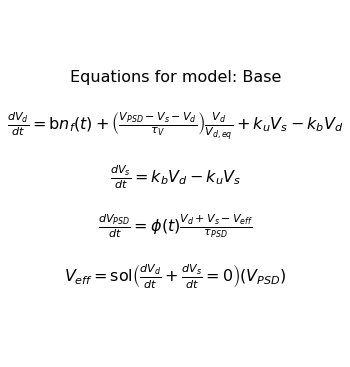

In [7]:
Sim.model_equations()

## Momentum Model -> A bit of a monster

So, this I can make work pretty well with the addition of a few extra parameter changes (one for enlarging the synapse, and one for the shrinkage). Biophysically, they're both plausible as they could account for the concentration of  dp- and p-cofilin (respectively active and inactive) in the synapse. In that case, the balance between polymerization and depolymerization is shifted. This could be introduced in the $V_d$ variable, but that would still not reproduce the complex STC experiments, which with this model we can do. One thing to look up is how long the dephosphorylated cofilin is present in large amounts during LTD. -> No luck so far..

MAYBE: You could define $V_e$ as the volume of the synapse in equilibrium (no nucleation), given a certain concentration of d-cofilin vs p-cofilin. This is the attractor for the stable and dynamic pool due to physical forces (as in Bonilla-Quintana-Fauth), and its value shifts depending on environmental conditions. Specifically, if the balance between inactive and active cofilin is shifted, the result will be a change in volume, as you'll either have uncontrolled severing (depression) or, depending on the amount of available actin close to the spine neck ($\sim Vs$), you will start constructing the enlargement pool. I have no clue if this is accurate, out of the few variations I implemented this seems to work the best. 
So in a way this acts as a proxy attractor for the PSD "volume", in the sense that the PSD will also be affected by these mechanisms, indirectly in the case of the enlargement pool, and directly in the case of severing (you're cutting down the actin supporting structure).

In [8]:
class MomentumModel(BaseModel):
    def latex_equations(self):
        eq = [r'$\frac{dV_d}{dt} = \mathrm{b}n_f(t) + \left(\frac{V_{e}-V_s-V_d}{\tau_V}\right)\frac{V_d}{V_{d,eq}} + k_uV_s - k_bV_d$',
              r'$\frac{dV_s}{dt} = k_bV_d - k_uV_s$',
              r'$\frac{dV_e}{dt} = \frac{k_b}{k_u}\frac{V_{tot}-V_eff}{\tau_{V_e}} + \frac{V_{psd}- V_e}{\tau_{decay}}$',
              r'$\frac{dV_{PSD}}{dt} = \phi(t) \frac{V_e-V_{psd}}{\tau_P}$']
        return eq
        
    def diff_equations_dict(self):
        _dict = super().diff_equations_dict()
        needed_variables = ["Ve"]
        for name in needed_variables:
            if not name in self.variables.varnames:
                raise ValueError(f"The variable {name} is needed for this model")
        _dict["Ve"] = self.dVe
        return _dict
    
    def set_initial_values(self,stochastic_model):
        super().set_initial_values(stochastic_model)
        self.variables.Ve = self.variables.Vpsd
    
    
    def dVd(self, t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        Vpsd = self.variables.Vpsd
        Ve = self.variables.Ve
        return self.nu*self.nf[t] - (Vd+Vs-Ve)/self.tau_Vd*(Vd/self.Vd_0)  - self.k_b[t] *Vd  + self.k_u[t] *Vs
 
    def dVe(self,t):
        V_tot = self.variables.V_tot
        V_eff = self.variables.V_eff
        Ve = self.variables.Ve
        Vd = self.variables.Vd
        Vs = self.variables.Vs
        Vpsd = self.variables.Vpsd
        return self.k_b[t]/self.k_u[t]*(V_tot - V_eff)/(self.tau_add_Ve) + (Vpsd - Ve)/(self.tau_Ve)
    
    def dPSD(self,t):
        Vs = self.variables.Vs
        Vd = self.variables.Vd
        V_eff = self.variables.V_eff
        Ve = self.variables.Ve
        Vpsd = self.variables.Vpsd
        PSD = self.protein[t]*(Ve - Vpsd)/(self.tau_PSD_mol) # ((np.sign(Ve-Vpsd)-1)/2)*(Vpsd-Ve)/self.tau_Ve
        return PSD
    
    def V_eff_calc(self, t):
        return super().V_eff_calc(t,attractor = self.variables.Ve)

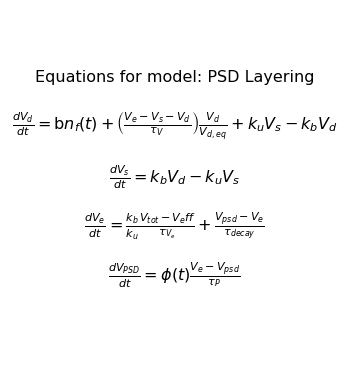

In [9]:
# Optimizing constants for this model
const_momentum = CONSTANTS.copy()
enlarge_dict = {# Enlargement pool
    # Crosslinker binding rates
    "k_u_0" : 1/2.5/3600, # Basal transition rates between stable and dynamic pool
    "k_b_0" : 1/2.5/600, # CaMKII active (unbound) for about 1 min after LTP (Lee et al 2009)
    "tau_add_Ve":5400, #5400
    "tau_Ve": 3300, # 33000
    # Dynamic pool timescale
    "tau_Vd": 4800} # 4800
const_momentum.update(enlarge_dict)
mom_model = MomentumModel("PSD Layering",{"Vd": None, "Vs": None, "Vpsd": 1., "V_eff": None,"V_tot": None,"Ve": None}, 
                            const = const_momentum,labels = variable_labels)
mom_model.experiments = create_experiments(mom_model)
Sim.add_model(mom_model,switching=False)
Sim.model_equations(["PSD Layering"])

# Early consolidation model

In [10]:
early_consolidation = BaseModel("EC", {"Vd":None,"Vs":None,"Vpsd":1,"V_eff":None,"V_tot":None},const = const_base,
                                labels = variable_labels)
early_consolidation.P_ONSET = 12.5 * 60
early_consolidation.nf_0 = 0.04
early_consolidation.nf_LTP = 15.2
early_consolidation.tau_Vd = 8000
early_consolidation.experiments = create_experiments(early_consolidation)
Sim.add_model(early_consolidation,switching=False)

# Running Experiments & Comparison

In [11]:
#mom_model.stop_recording_variables("V_eff")
LTP_LTD_NAMES = ["S_TET","LTD","W_TET", "W_LFS",]
M_NAMES = ["LTP_X2","MULTI_LTP_BEFORE_PRP"]
exp_name = "W_TET"
exp_title = "Weak HFS"
exp_multi_title = ["STC LTP SBW", "STC LTD SBW"]
for model in ["Base","PSD Layering"]:
    Sim.switch_model(model)
    multiple = [Sim.models[model].experiments["Basic"].get_experiment(name) for name in M_NAMES]
    ltp_ltd = [Sim.models[model].experiments["Basic"].get_experiment(name) for name in LTP_LTD_NAMES]
    stc_base = [Sim.models[model].experiments["STCLTP"][k] for k in range(len(Sim.models[model].experiments["STCLTP"]))]
    for k in range(len(Sim.models[model].experiments["STCLTD"])):
        stc_base.append(Sim.models[model].experiments["STCLTD"][k])
    extended = [exp for exp in ltp_ltd]
    for k in range(len(stc_base)):
        extended.append(stc_base[k])
    cplx_stc = Sim.models[model].experiments["TR"]
    single_exp = Sim.models[model].experiments["Basic"].get_experiment(exp_name)
    if not isinstance(single_exp,Experiments):
        single_exp.title = exp_title
    else:
        for i,exp in enumerate(single_exp):
            exp.title = exp_multi_title[i]
    _ = Sim.run_experiments(single_exp,n_of_runs=10,stochastic=True,termalize=True,record_termalization=False)
    # #Adding a reference for TR experiments
    # ltp_results = Sim.run_experiments(single_exp,save_results=False)
    # for n in [0,1]:
    #     Sim.model_results[model][n]["V_tot_ref"] = ltp_results[0]["V_tot"]
    #     Sim.model_results[model][n]["Vpsd_ref"] = ltp_results[0]["Vpsd"]
    #     Sim.model.labels["V_tot_ref"] = r'$V_{tot,LTP}$'
    #     Sim.model.labels["Vpsd_ref"] = r'$V_{PSD,LTP}$'

Simulating 1 experiments took: 10.882 s
Simulating 1 experiments took: 11.167 s


In [12]:
# Sim.switch_model("PSD Layering")
# Sim.plot_results(time_interval = [0,3600],filename="W_TET_detail-PSD_Layerinh.png")

Plotting 2 experiments
0
0


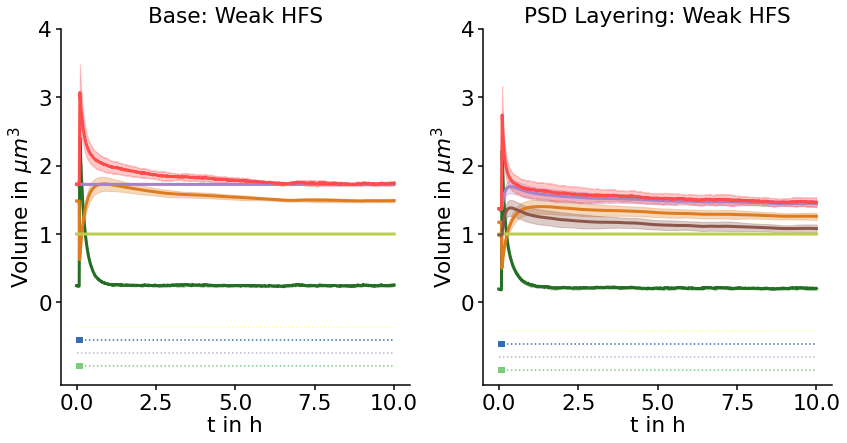

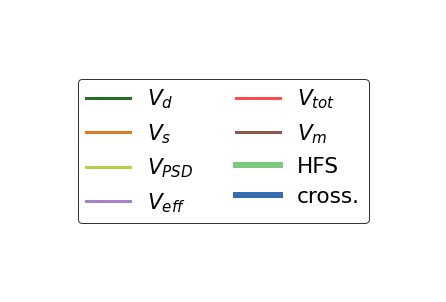

In [13]:
Sim.plot_comparison(filename = f"{exp_name}_all_models.png", time_unit = 'h',
fontsize = 18,use_title = True,separate_legend = True)

Simulating 1 experiments took: 0.361 s
Simulating 1 experiments took: 0.340 s
Simulating 1 experiments took: 0.324 s


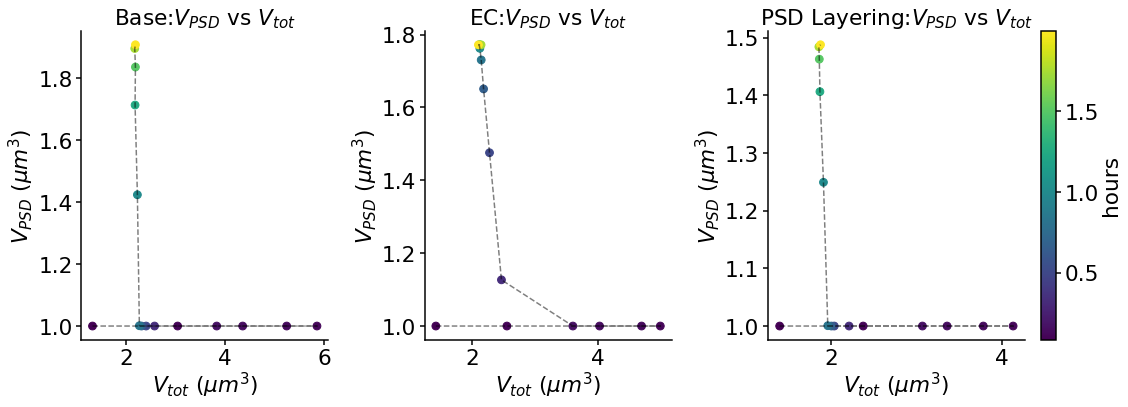

In [14]:
import matplotlib.collections as mcoll
from itertools import chain

time_points = [[k for k in range(5*60,10*60,60)]]
time_points.append([k for k in range(10*60,3600,600)])
time_points.append([3600,int(75/60*3600),int(1.5*3600),int(105/60*3600),2*3600-1])
time_points = np.array([item for sublist in time_points for item in sublist])
Vtot = []
Vpsd = []
for i,model in enumerate(["Base","EC","PSD Layering"]):
    results = Sim.run_experiments(Sim.models[model].experiments["Basic"].get_experiment("S_TET"),n_of_runs=1,stochastic=True,termalize=True,record_termalization=False)
    Vpsd.append(results[0]["Vpsd"][time_points])
    Vtot.append(results[0]["V_tot"][time_points])
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1,1,1.3]},figsize = (16,6))
for i,model in enumerate(["Base","EC","PSD Layering"]):
    fig.add_subplot(1,3,i+1)
    ax[i].set_axis_off()
    plt.plot(Vtot[i],Vpsd[i],c = "k",alpha = 0.5,ls = '--')
    plt.scatter(Vtot[i],Vpsd[i], c = time_points/3600, cmap = "viridis",s = 60)
    plt.title(f"{model}:"+r'$V_{PSD}$ vs $V_{tot}$')
    plt.xlabel(r"$V_{tot}$ ($\mu m^3$)")
    plt.ylabel(r"$V_{PSD}$ ($\mu m^3$)")
    if i == 2:
        cb = plt.colorbar()
        cb.set_label("hours")
    plt.tight_layout()
plt.savefig("plots/vpsd-vs-vtot_all_models.png")
plt.show()

In [15]:
# exp_names = ["NO_STIMULI"]
# Sim.switch_model("Base")
# stoch_det_results = []
# for name in exp_names:
#     exp = Sim.model.experiments["Basic"].get_experiment(name)
#     stoch = Sim.run_experiments(exp,100,stochastic=True,termalize = True)
#     det = Sim.run_experiments(exp)
#     stoch_det_results.append([stoch[0],det[0]])

In [16]:
# mean_stoch = np.mean(stoch_det_results[0][0]["V_tot"])
# std_stoch = np.std(stoch_det_results[0][0]["V_tot"])
# mean_det =stoch_det_results[0][1]["V_tot"][-1] 
# print(mean_stoch,std_stoch,mean_det)
# Sim.compare_experiment_results(stoch_det_results[0],["V_tot"], figsize = (12,6),stochastic_styling = "mean_traces_1",
# rescale = True, time_unit = "h",filename = f"NO_STIMULI-stoch-det.png",use_legend = True,multi_plot=1,
# xlabel = "t in hours", ylabel = r"$V_{tot}$ in $\mu m^3$")

In [17]:
# Sim.compare_experiment_results([stoch[0],det[0]],["V_tot"],stochastic_styling = "mean_traces_1",
#  rescale = True, time_unit = "h",filename = "LTP-stoch-det.png",use_legend = True)

# Tag reset experiments comparison

In [18]:
do_not_record = {
    "Vd" : False,
    "Vs" : False,
    "V_eff": False
}
# TODO allow for comparison of different model results!
tr_results = []
reference_values=[]
x_data = []
for idx,model in enumerate(["Base","EC","PSD Layering"]):
    # Sim.models[model].stop_recording_variables(do_not_record)
    Sim.switch_model(model)
    tr_results.append(Sim.run_experiments(Sim.model.experiments["TR_extended"],save_results=False))
    reference_LTP = Sim.run_experiments(Sim.model.experiments["Basic"].get_experiment("S_TET"))
    x_data = np.array([tr_results[idx][i]["experiment"].LFS[0][0] -300 for i in range(len(tr_results[idx]))])/60
    # Take as reference the value of the PSD after potentiation
    reference_values.append([reference_LTP[0]["Vpsd"][-1],1])


Simulating 29 experiments took: 1.174 s
Simulating 1 experiments took: 0.136 s
Simulating 29 experiments took: 1.304 s
Simulating 1 experiments took: 0.116 s
Simulating 29 experiments took: 1.484 s
Simulating 1 experiments took: 0.154 s


Making 1 plots
Figsize (18, 6.5)
Making 1 plots
Making 1 plots


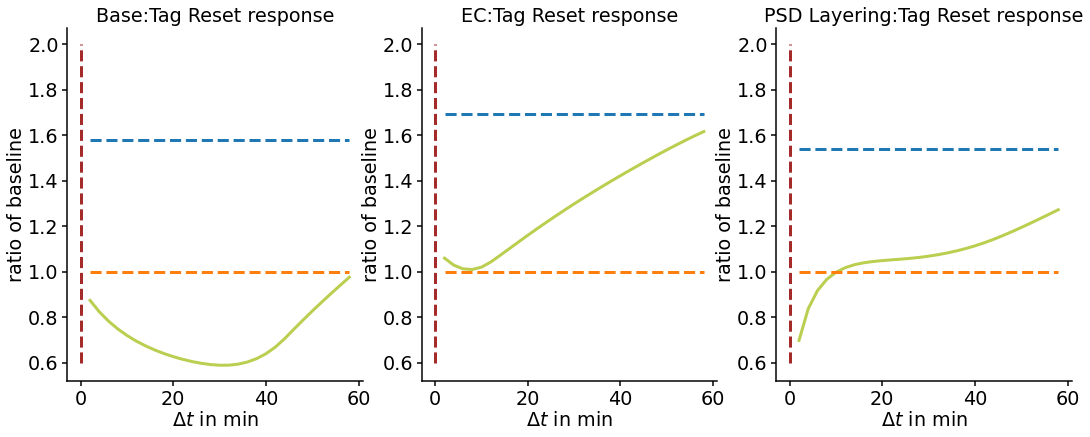

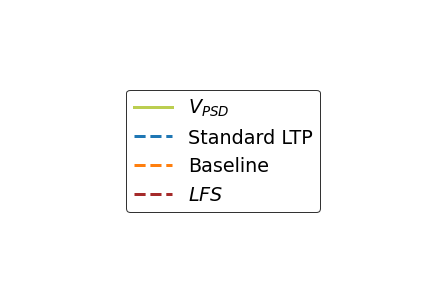

In [19]:
Sim.plot_selected_points(tr_results,"Vpsd","last",title = "Tag Reset response",event_type="LFS", x_data = x_data, reference_values=reference_values,
                ref_labels = ['Standard LTP','Baseline'],filename = f"none.png",x_label = "t in min",
                multi_plot=3, xlabel = r'$\Delta t$ in min',separate_legend = True,fontsize = 16)

# Metaplasticity experiments and comparison

In [20]:
# meta_results = []
# for model in ["Base","EC","PSD Layering"]:
#     Sim.switch_model(model)
#     LTP_META = Sim.model.experiments["Metaplasticity"].get_experiment("LTP_META")
#     meta_results.append( Sim.run_experiments(LTP_META)[0])
#     x_data = np.arange(1,len(LTP_META.stim)+1,1)
# print(len(x_data))


In [21]:
# Sim.plot_selected_points(meta_results,["Vpsd","V_tot"],"last_before_event",["stim","LFS"],
# filename = f"LTP_META.png",x_data = x_data, separate_legend = False, fontsize = 18)

## Linear regression for Vpsd vs Vtot relation

In [22]:
# from scipy.stats import linregress
# meta_results = []
# V_psd_points = []
# V_tot_points = []
# for k,model in enumerate(["Base", "PSD Layering"]):
#     Sim.switch_model(model)
#     LTP_META = Sim.model.experiments["Metaplasticity"].get_experiment("LTP_META")
#     meta_results = Sim.run_experiments(LTP_META)[0]
#     exp = meta_results["experiment"]
#     V_psd_points.append(meta_results["Vpsd"][[int((s[0]-10)/exp.dt) for s in exp.stim]])
#     V_tot_points.append(meta_results["V_eff"][[int((s[0]-10)/exp.dt) for s in exp.stim]]) 

In [23]:
# fig = plt.figure(figsize = (12,5))
# for k in range(2):
#     linear_regression = linregress(V_tot_points[k],V_psd_points[k])
#     a = linear_regression.intercept
#     b = linear_regression.slope
#     estimate = [a+V_tot_points[k][i]*b for i in range(len( V_tot_points[k] ))]
#     fig.add_subplot(1,2,k+1)
#     plt.plot(V_tot_points[k], V_psd_points[k], label = "Observed results",lw = 3,color = "#ff4d4d")
#     plt.plot(V_tot_points[k],estimate,ls = '--',alpha = 0.7,color = "k",label = "Regression")

#     plt.title("Base model" if k == 0 else "PSD Layering model")
#     plt.xlabel(r'$V_{tot}$')
#     plt.ylabel(r'$V_{PSD}$')
# plt.legend(loc = "lower left", bbox_to_anchor = (1.0,0))
# plt.tight_layout()
# fig.savefig(f"plots/psd-regression.png")
# plt.show()

In [24]:
# idx_dict = {
#     "Base" : 0,
#     "PSD Layering": 2,
#     "EC" : 1
# }
# multi = []
# ref = []
# if not isinstance(meta_results,list):
#     meta_results = [meta_results]
# for model in ["Base","EC","PSD Layering"]:
#     idx = idx_dict[model]
#     Sim.switch_model(model)
#     MULTI_LTP = Sim.model.experiments["Multi_LTP"]
#     MULTI_LTP[0].title = "Early LTP Spacing"
#     multi.append(Sim.run_experiments(MULTI_LTP))
#     x_data = np.arange(0,len(MULTI_LTP.experiments),1)
#     times = [int((meta_results[idx]["experiment"].stim[k][0] - 10)/meta_results[idx]["experiment"].dt) for k in range(len( meta_results[idx]["experiment"].stim))]
#     ref.append( [meta_results[idx]["V_tot"][k] for k in times[:len(x_data)]])
# Sim.plot_selected_points(multi,["Vpsd","V_tot"],"last",reference_data = ref,ref_data_labels = "additive",filename="multi-LTP.png",
#                          multi_plot=3,separate_legend = True, fontsize = 18)

In [25]:
# spacing = []
# reference_values = []
# for model in ["Base","EC","PSD Layering"]:
#     Sim.switch_model(model)
#     LTP_SPACING = Sim.model.experiments["Spacing"]
#     LTP_SPACING[0].title = "LTP spacing"
#     spacing.append(Sim.run_experiments(LTP_SPACING))
#     x_data = [exp.stim[1][1]-300-STET for exp in LTP_SPACING.experiments[1:]]
#     x_data.insert(0,0)
#     x_data = np.array(x_data)/60
#     reference_values.append([spacing[-1][0]["Vpsd"][-1],spacing[-1][-1]["Vpsd"][-1]])
#     reference_labels = [r"$V_{PSD}$ 1xLTP", r"$V_{PSD}$ 2xLTP"]
# Sim.plot_selected_points(spacing,["Vpsd","V_tot"],"last",x_data=x_data, fontsize = 18,
# reference_values = reference_values, ref_labels = reference_labels, filename="LTP-spacing.png",multi_plot = 3,
# xlabel = r'$\Delta t$ in min', separate_legend = True )

In [26]:
protein_results = []
for model in ["Base","PSD Layering"]:
    Sim.switch_model(model)
    exp = Sim.model.experiments["ProteinTimeLTP"]
    protein_results.append(Sim.run_experiments(exp))

Simulating 81 experiments took: 6.804 s
Simulating 81 experiments took: 9.314 s


Making 1 plots
Figsize (14, 6.5)
Making 1 plots


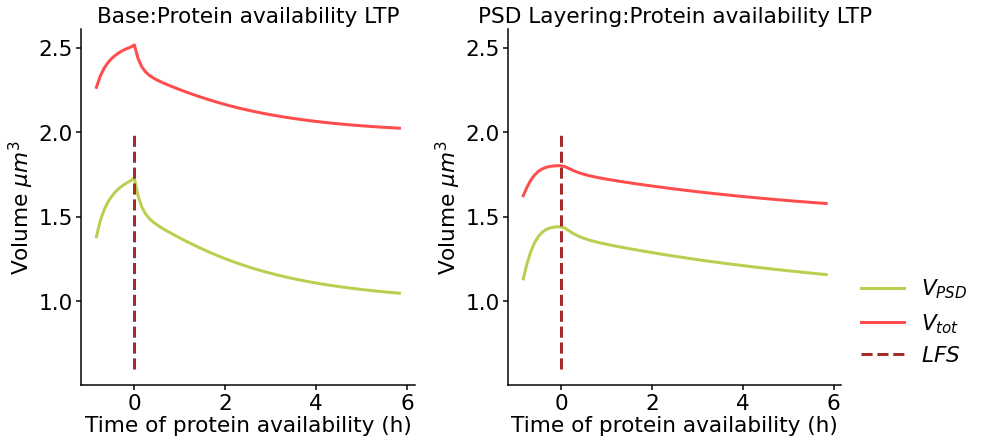

In [27]:
x_data = (np.arange(900,7*3600,300) - PROTEIN - 300)/3600
Sim.plot_selected_points(protein_results,["Vpsd","V_tot"],"last",["stim"], x_data= x_data,xlabel = "Time of protein availability (h)",
ylabel = r"Volume $\mu m^3$", filename = f"LTP_protein_times_all_models.png", separate_legend = False, fontsize = 18,multi_plot=2)

In [28]:
protein_results = []
for model in ["Base","PSD Layering"]:
    Sim.switch_model(model)
    exp = Sim.model.experiments["ProteinTimeLTD"]
    protein_results.append(Sim.run_experiments(exp))

Simulating 81 experiments took: 7.432 s
Simulating 81 experiments took: 8.485 s


Making 1 plots
Figsize (14, 6.5)
Making 1 plots


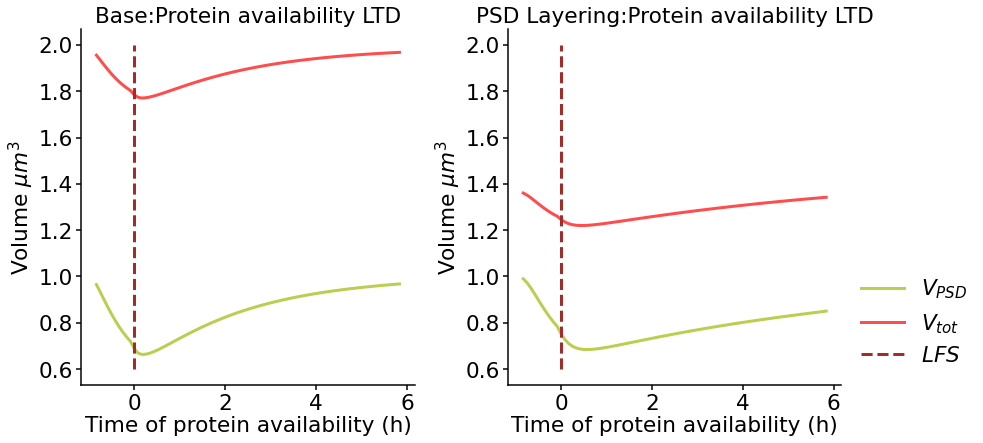

In [30]:
x_data = (np.arange(900,7*3600,300) - PROTEIN - 300)/3600
Sim.plot_selected_points(protein_results,["Vpsd","V_tot"],"last",["stim"], x_data= x_data,xlabel = "Time of protein availability (h)",
ylabel = r"Volume $\mu m^3$", filename = f"LTD_protein_times_all_models.png", separate_legend = False, fontsize = 18,multi_plot=2)

# Next steps:
- Optimize the TagResetting result for Momentum model.
- Find biological explanation for the "gating" of the $V_e$ variable
- Find better names for constants and variables
- (MAYBE) Try including the receptor content based on Moritz 2021, just to see if it comes out